In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
import sklearn
from sklearn.metrics import roc_auc_score
import random

random.seed(0)
import numpy as np
import lime
import lime.lime_tabular

In [2]:
def getMNIST():
    t0 = time.time()
    train_samples = 60000
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    X = X.reshape((X.shape[0], -1))
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print("==================")
    X_train=list(X_train)
    X_test=list(X_test)
    print(len(X_train))
    print(len(X_test))
    print("==================")
    
    return X_train, y_train, X_test, y_test

In [20]:
def make_38_Subset(X_train, y_train, X_test, y_test):
    templist = []
    for tup in zip(X_train, y_train):
        if(tup[1]=='8' or tup[1]=='3'):
            templist.append(list(tup))

    testList = []
    for tup in zip(X_test, y_test):
        if(tup[1]=='8' or tup[1]=='3'):
            testList.append(list(tup))

    print("3/8 Training set size = "+str(len(templist)))
    print("3/8 Test set size = "+str(len(testList)))
    
    X_test=[]
    y_test=[]

    for tup in testList:
        X_test.append(tup[0])
        y_test.append(tup[1])


    #seed_size=int(0.1*len(templist))
    seed_size = 5
    seed_list=templist[0:seed_size]
    print("Initial Seed set size = "+str(len(seed_list)))
 
    unlabelled_list=templist[seed_size:25]
    print("Unlabelled dataset size = "+str(len(unlabelled_list)))
    
    return seed_list, unlabelled_list, X_test, y_test

In [21]:
def select_based_on_explanation_from_unlabeled(seed_list, unlabelled_list, batch_size, clf):
    print(len(seed_list))
    print(len(unlabelled_list))
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
       
    feature_names=[]

    for i in range(784):
        feature='feature_'+str(i)
        feature_names.append(feature)
    

    class_names=[]
    classes=['3','8']

    for i in classes:
        class_1='class_'+str(i)
        class_names.append(class_1)
    
    
    seed_X=[]
    seed_y=[]

    for tup in seed_list:
        seed_X.append(list(tup[0]))
        seed_y.append(list(tup[1]))
        
        
    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(seed_X), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    
    
    total_np_array=[]
    for item in seed_list:
        #print(item)
        exp = explainer.explain_instance(item[0], clf.predict_proba, num_features=784)
        #print(exp.as_list())
        vectors = np.empty([1, 784])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        total_np_array.append(vectors[0])
        
    
    seed_mean = np.mean(np.array(total_np_array), axis=0)
    
    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(ulabelled_X), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    
    del_s = [] # new points to add to s
    
    sums=[]
    for item in unlabelled_list:
        #print(item[0])
        exp = explainer.explain_instance(np.array(item[0]), clf.predict_proba, num_features=784)
        #print(exp.as_list)
        vectors = np.empty([1, 784])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        np_vector=vectors[0]
        sums.append(np.sum(np.subtract(seed_mean, np_vector)))
    
    #print("Sum length="+str(len(sums)))
    for i in range(batch_size):
        max_index=sums.index(max(sums))
        del_s.append(unlabelled_list[max_index])
        del unlabelled_list[max_index]
        del sums[max_index]
    
    #print("Sum length="+str(len(sums)))
    #print(len(unlabelled_list))
    
    return del_s, unlabelled_list

In [22]:
def select_based_on_explanation_from_unlabeled_based_on_seed_set_split(seed_list, unlabelled_list, batch_size, clf):
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
       
    feature_names=[]

    for i in range(784):
        feature='feature_'+str(i)
        feature_names.append(feature)
    

    class_names=[]
    classes=['3','8']

    for i in classes:
        class_1='class_'+str(i)
        class_names.append(class_1)
    
    
    seed_X=[]
    seed_y=[]

    for tup in seed_list:
        seed_X.append(list(tup[0]))
        seed_y.append(list(tup[1]))
        
        
    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(seed_X), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    
    
    total_np_array=[]
    for item in seed_list:
        #print(item)
        exp = explainer.explain_instance(item[0], clf.predict_proba, num_features=784)
        #print(exp.as_list())
        vectors = np.empty([1, 784])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        total_np_array.append(vectors[0])
        
    
    seed_mean = np.mean(np.array(total_np_array), axis=0)
    
    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(ulabelled_X), feature_names=feature_names, class_names=class_names, discretize_continuous=False)
    
    del_s = [] # new points to add to s
    
    sums=[]
    for item in unlabelled_list:
        #print(item[0])
        exp = explainer.explain_instance(np.array(item[0]), clf.predict_proba, num_features=784)
        #print(exp.as_list)
        vectors = np.empty([1, 784])
        for elem in list(exp.as_list()):
            np.append(vectors, elem[1], axis=None)
        np_vector=vectors[0]
        sums.append(np.sum(np.subtract(seed_mean, np_vector)))
    
    #print("Sum length="+str(len(sums)))
    for i in range(batch_size):
        max_index=sums.index(max(sums))
        del_s.append(unlabelled_list[max_index])
        del unlabelled_list[max_index]
        del sums[max_index]
    
    #print("Sum length="+str(len(sums)))
    #print(len(unlabelled_list))
    
    return del_s, unlabelled_list

In [23]:
def select_based_on_uncertainity_from_unlabeled(unlabelled_list, batch_size, clf):
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
        
    modified_u = [] # modified unlabeled
    del_s = [] # new points to add to s
    
    for i in range(batch_size):
        predictions_label_wise=np.array(clf.predict_proba(ulabelled_X))
        uncertainity_list = list(1-predictions_label_wise.max(axis=1))
        max_index = uncertainity_list.index(max(uncertainity_list))
        del unlabelled_list[max_index]
        modified_u = unlabelled_list
        del_s.append(unlabelled_list[max_index])
    
    print(len(del_s))
    print(len(modified_u))
    return del_s, modified_u

In [24]:
def train_model(data, X_test, y_test):
    print("--------------------Start------------------")
    train_samples = 60000
    clf = LogisticRegression(C=50. / train_samples, penalty='l2', solver='saga', tol=0.1)
    print("Training with seed size: " + str(len(data)))
    #random.shuffle(data)
    X_train=[]
    y_train=[]
    for i in range(len(data)):
        try:
            #print(data[i][1])
            X_train.append(list(data[i][0]))
            y_train.append(data[i][1])
        except:
            pass
        
    clf.fit(X_train, y_train)
    accuracy = sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))
    print("Accuracy on the Test Set is : "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))
    print("--------------------End------------------")
    return clf, accuracy

In [25]:
print ("Making MNIST data...")
X_train, y_train, X_test, y_test = getMNIST()

Making MNIST data...
60000
10000


In [10]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 1
niters = 10

explanation_accuracies = []
seed_set_size = []

for i in range(niters):
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    explanation_accuracies.append(accuracy)
    seed_set_size.append(len(s))

    del_s, u = select_based_on_explanation_from_unlabeled(s, u, batch_size, clf)
    s = s + del_s
    

Getting MNIST 3/8 classification data...
3/8 Training set size = 11946
3/8 Test set size = 2020
Initial Seed set size = 5
Unlabelled dataset size = 20
|S|_0 = 5, |U|_0 = 20
--------------------Start------------------
Training with seed size: 5
Accuracy on the Test Set is : 0.7886138613861386
--------------------End------------------
5
20
|S|_1 = 6, |U|_1 = 19
--------------------Start------------------
Training with seed size: 6
Accuracy on the Test Set is : 0.7628712871287129
--------------------End------------------
6
19
|S|_2 = 7, |U|_2 = 18
--------------------Start------------------
Training with seed size: 7
Accuracy on the Test Set is : 0.8193069306930693
--------------------End------------------
7
18
|S|_3 = 8, |U|_3 = 17
--------------------Start------------------
Training with seed size: 8
Accuracy on the Test Set is : 0.851980198019802
--------------------End------------------
8
17
|S|_4 = 9, |U|_4 = 16
--------------------Start------------------
Training with seed size: 9
A

In [11]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 1
#stopping_criteria = int(len(unlabelled_list)/100)
#print(len(X_test))

niters = 10

max_uncertainity_accuracies = []
seed_set_size = []

for i in range(niters):
    
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    max_uncertainity_accuracies.append(accuracy)
    seed_set_size.append(len(s))
    
    del_s, u = select_based_on_uncertainity_from_unlabeled(u, batch_size, clf)
    s = s + del_s

Getting MNIST 3/8 classification data...
3/8 Training set size = 11946
3/8 Test set size = 2020
Initial Seed set size = 5
Unlabelled dataset size = 20
|S|_0 = 5, |U|_0 = 20
--------------------Start------------------
Training with seed size: 5
Accuracy on the Test Set is : 0.7846534653465347
--------------------End------------------
1
19
|S|_1 = 6, |U|_1 = 19
--------------------Start------------------
Training with seed size: 6
Accuracy on the Test Set is : 0.7405940594059406
--------------------End------------------
1
18
|S|_2 = 7, |U|_2 = 18
--------------------Start------------------
Training with seed size: 7
Accuracy on the Test Set is : 0.7183168316831683
--------------------End------------------
1
17
|S|_3 = 8, |U|_3 = 17
--------------------Start------------------
Training with seed size: 8
Accuracy on the Test Set is : 0.7910891089108911
--------------------End------------------
1
16
|S|_4 = 9, |U|_4 = 16
--------------------Start------------------
Training with seed size: 9


IndexError: list index out of range

In [14]:
max_uncertainity_accuracies, explanation_accuracies[0:5]

([0.7846534653465347,
  0.7405940594059406,
  0.7183168316831683,
  0.7910891089108911,
  0.7886138613861386],
 [0.7886138613861386,
  0.7628712871287129,
  0.8193069306930693,
  0.851980198019802,
  0.8539603960396039])

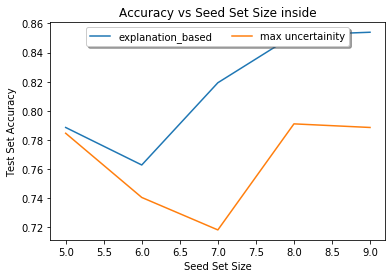

In [16]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(seed_set_size, explanation_accuracies[0:5], label='explanation_based')
ax.plot(seed_set_size, max_uncertainity_accuracies, label='max uncertainity')
plt.title('Legend inside')
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.xlabel('Seed Set Size')
plt.ylabel('Test Set Accuracy')
plt.title('Accuracy vs Seed Set Size inside')
plt.show()
plt.show()

In [17]:
import numpy as np
import numpy.random as npr

def select_random_from_unlabeled(u, batch_size):
    selected = set(npr.choice(len(u), batch_size, replace=False)) #these will no longer be unlabeled
    
    modified_u = [] # modified unlabeled
    del_s = [] # new points to add to s
    
    i=0
    for x in u:
        if i in selected:
            del_s.append(x)
        else:
            modified_u.append(x)
            
        i=i+1
    return del_s, modified_u

In [18]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 1
#stopping_criteria = int(len(unlabelled_list)/100)
#print(len(X_test))

niters = 5

random_accuracies = []
seed_set_size=[]

for i in range(niters):
    
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    random_accuracies.append(accuracy)
    seed_set_size.append(len(s))    
    
    del_s, u = select_random_from_unlabeled(u, batch_size)
    s = s + del_s
    

Getting MNIST 3/8 classification data...
3/8 Training set size = 11946
3/8 Test set size = 2020
Initial Seed set size = 5
Unlabelled dataset size = 20
|S|_0 = 5, |U|_0 = 20
--------------------Start------------------
Training with seed size: 5
Accuracy on the Test Set is : 0.7371287128712871
--------------------End------------------
|S|_1 = 6, |U|_1 = 19
--------------------Start------------------
Training with seed size: 6
Accuracy on the Test Set is : 0.7589108910891089
--------------------End------------------
|S|_2 = 7, |U|_2 = 18
--------------------Start------------------
Training with seed size: 7
Accuracy on the Test Set is : 0.7262376237623762
--------------------End------------------
|S|_3 = 8, |U|_3 = 17
--------------------Start------------------
Training with seed size: 8
Accuracy on the Test Set is : 0.7688118811881188
--------------------End------------------
|S|_4 = 9, |U|_4 = 16
--------------------Start------------------
Training with seed size: 9
Accuracy on the Test

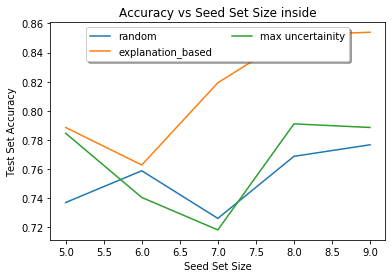

In [19]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(seed_set_size, random_accuracies, label='random')
ax.plot(seed_set_size, explanation_accuracies[0:5], label='explanation_based')
ax.plot(seed_set_size, max_uncertainity_accuracies, label='max uncertainity')
plt.title('Legend inside')
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.xlabel('Seed Set Size')
plt.ylabel('Test Set Accuracy')
plt.title('Accuracy vs Seed Set Size inside')
plt.show()
plt.show()